# Import the data

In [1]:
import pandas as pd 


df_train = pd.read_csv("data/X_train.csv")
df_test = pd.read_csv("data/X_test.csv")

In [2]:
df_train = df_train
df_test = df_test

# Visualize few trajectories

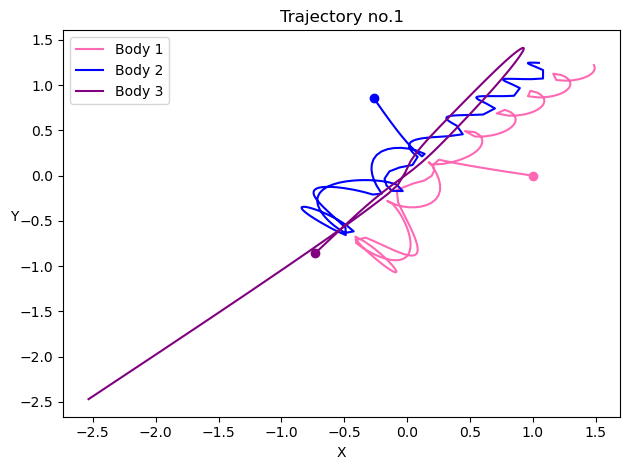

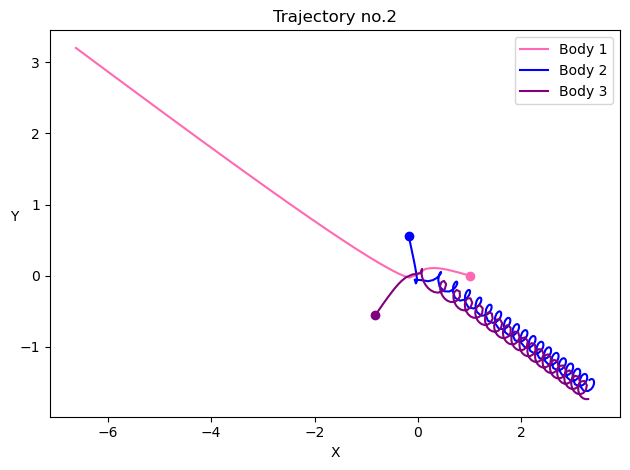

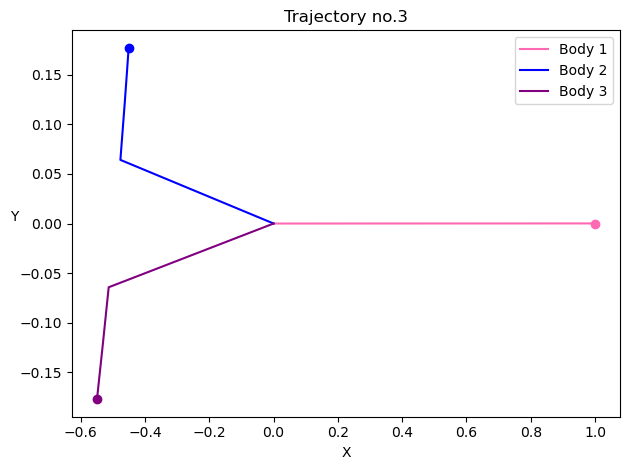

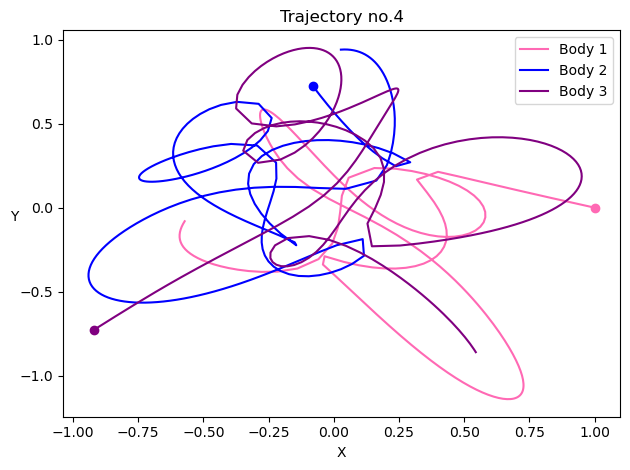

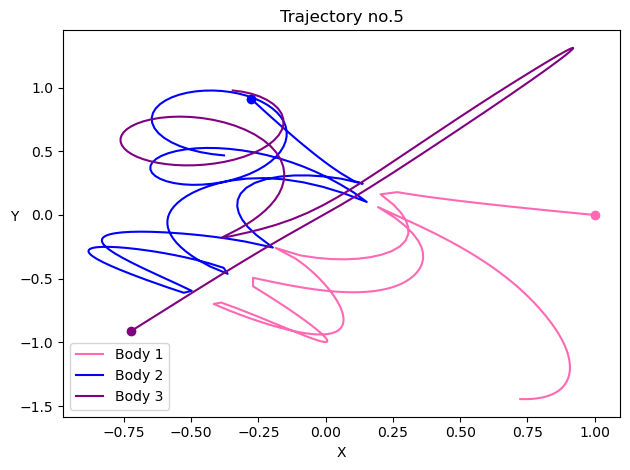

In [3]:
import matplotlib.pyplot as plt

start = 0
end = 257

for i in range(5):
    trajectory = df_train[start:end]
    x1, y1, x2, y2, x3, y3 = trajectory.x_1, trajectory.y_1, trajectory.x_2, trajectory.y_2, trajectory.x_3, trajectory.y_3
    plt.plot(x1, y1, color="hotpink", label = "Body 1")
    plt.plot(x2, y2, color="blue", label = "Body 2")
    plt.plot(x3, y3, color="purple", label = "Body 3")
    plt.scatter(x1[start], y1[start], color="hotpink")
    plt.scatter(x2[start], y2[start], color="blue")
    plt.scatter(x3[start], y3[start], color="purple")
    plt.xlabel("X")
    plt.ylabel("Y", rotation=0)
    plt.title("Trajectory no." + str(i+1))
    plt.legend()
    plt.tight_layout()
    plt.show()

    start += 257
    end += 257


# Prepare the dataset

In [4]:
df_train["group"] = df_train["Id"]//257

In [5]:
#All starting positions
df_init = df_train[ df_train.index%257 == 0]

In [6]:
df_combined = df_train.merge(df_init, on="group",  suffixes=('', '_init'))

In [7]:
X = df_combined[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
X.head()

,t,x_1_init,y_1_init,x_2_init,y_2_init,x_3_init,y_3_init
0,0.000000,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
1,0.039062,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
2,0.078125,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
3,0.117188,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
4,0.156250,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196


In [8]:
y = df_combined[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
y

,x_1,y_1,x_2,y_2,x_3,y_3
0,1.000000,0.000000,-0.266467,0.859196,-0.733533,-0.859196
1,0.999548,0.000092,-0.266261,0.858781,-0.733287,-0.858874
2,0.998190,0.000370,-0.265641,0.857535,-0.732549,-0.857905
3,0.995925,0.000833,-0.264606,0.855456,-0.731318,-0.856289
4,0.992747,0.001483,-0.263154,0.852540,-0.729592,-0.854022
...,...,...,...,...,...,...
1284995,-0.022787,-0.354678,-0.128897,-0.618452,0.151684,0.973131
1284996,-0.082072,-0.384254,-0.084507,-0.627569,0.166578,1.011822
1284997,-0.140434,-0.438907,-0.040823,-0.610311,0.181257,1.049218
1284998,-0.177344,-0.524277,-0.018380,-0.561151,0.195724,1.085428


In [9]:
groups = df_combined["group"]
groups

0             0
1             0
2             0
3             0
4             0
           ... 
1284995    4999
1284996    4999
1284997    4999
1284998    4999
1284999    4999
Name: group, Length: 1285000, dtype: int64

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(random_state=1, max_iter=3)
svm = SVR(kernel="linear")
model = LinearRegression()
model_ridge = Ridge()
model_lasso = Lasso()

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", model_ridge)
    ])
pipe

Pipeline(steps=[('scaling', StandardScaler()), ('model', Ridge())])

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

kfold = GroupKFold(n_splits=5)

rmse_list = [] 
y_hats = []
    
for fold_num, (train_index, test_index) in enumerate(kfold.split(X, y, groups=groups)):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    print("Fold")
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    y_hats.append(y_hat)
    rmse_list.append(mean_squared_error(y_test, y_hat, squared = False))

print(rmse_list)
print("AVG:", sum(rmse_list)/len(rmse_list))

Fold
Fold
Fold
Fold
Fold
[1.4325084898995042, 1.2183607861834531, 1.2541316111468312, 1.1376054221164562, 1.3192516882387144]
AVG: 1.2723715995169917


In [13]:
import numpy as np

def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()

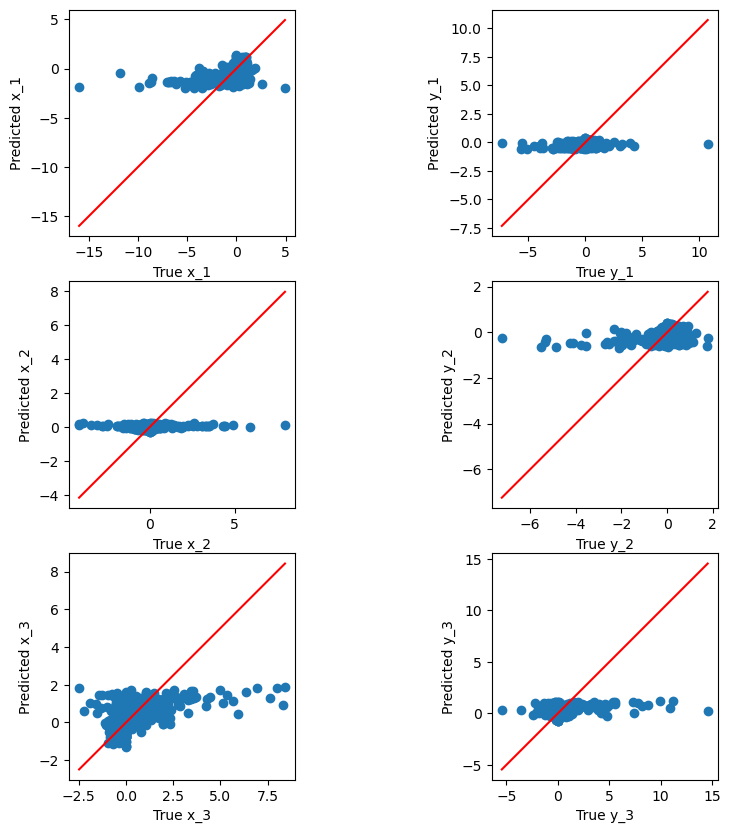

In [14]:
plot_y_yhat(y_test.to_numpy(), pd.DataFrame(y_hat).to_numpy())

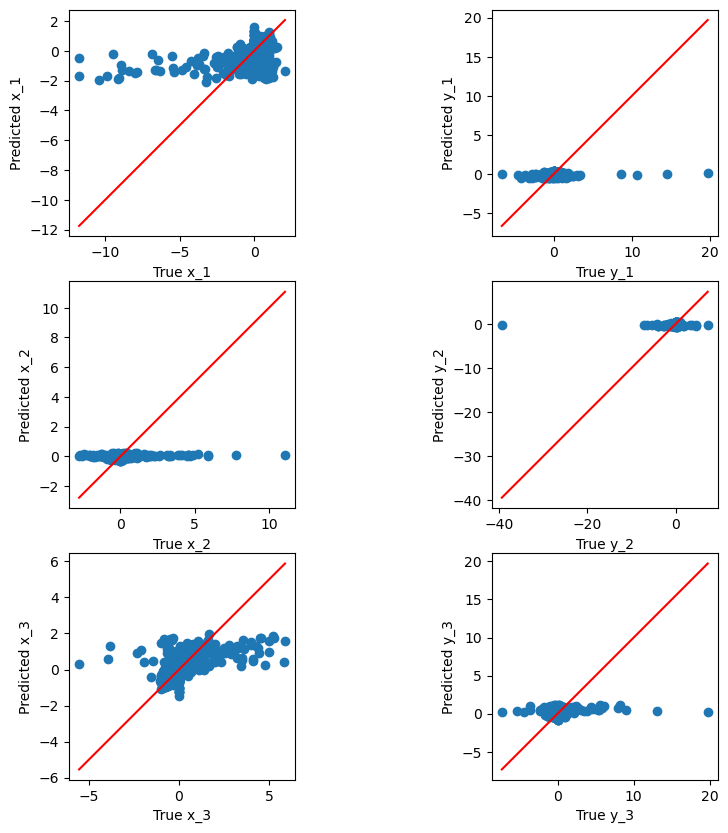

In [15]:
plot_y_yhat(y_test.to_numpy(), pd.DataFrame(y_hat).to_numpy())

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [17]:
pipe2= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=3)),
            ('model', Ridge())
    ])

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV

kfold2 = GroupKFold(n_splits=10)

pipe2= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=2)),
        ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

for fold_num, (train_index, test_index) in enumerate(kfold2.split(X, y, groups=groups)):
    # Indexing with iloc
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    pipe2.fit(X_train, y_train)

    n_features = pipe2.named_steps['preprocessor'].n_output_features_
    print(n_features)

    y_train_predict = pipe2.predict(X_train)
    y_val_predict = pipe2.predict(X_test)


    train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))
    print("Train MSE:", train_error)

    test_error = np.sqrt(mean_squared_error(y_test, y_val_predict))
    print("Test MSE:", test_error)

36
Train MSE: 1.2377723919848405
Test MSE: 1.5447971134504872
36
Train MSE: 1.2744839859754302
Test MSE: 1.2471155913783234
36
Train MSE: 1.2823678970822372
Test MSE: 1.1723758907384112
36
Train MSE: 1.2865629213357261
Test MSE: 1.13020152418571
36
Train MSE: 1.2705432784932946
Test MSE: 1.2833519412768555
36
Train MSE: 1.2692685249505196
Test MSE: 1.2959362540914345
36
Train MSE: 1.2794656395383275
Test MSE: 1.2002579696887707
36
Train MSE: 1.2632722318595768
Test MSE: 1.3464787455283818
36
Train MSE: 1.2863786924280711
Test MSE: 1.1321561655824426
36
Train MSE: 1.265678473145735
Test MSE: 1.3260127370205625


In [20]:
kfold3 = GroupKFold(n_splits=10)

pipe3= Pipeline(
        [       ('preprocessor', PolynomialFeatures(degree=3)),
                ('model', Ridge())
        ])

for fold_num, (train_index, test_index) in enumerate(kfold3.split(X, y, groups=groups)):
    # Indexing with iloc
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    pipe3.fit(X_train, y_train)

    n_features = pipe3.named_steps['preprocessor'].n_output_features_
    print(n_features)

    y_train_predict = pipe3.predict(X_train)
    y_val_predict = pipe3.predict(X_test)


    train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))
    print("Train MSE:", train_error)

    test_error = np.sqrt(mean_squared_error(y_test, y_val_predict))
    print("Test MSE:", test_error)

120
Train MSE: 1.201458182083826
Test MSE: 1.520030869800424
120
Train MSE: 1.2386134102768942
Test MSE: 1.221633101081073
120
Train MSE: 1.2477911405008788
Test MSE: 1.1344495364107314
120
Train MSE: 1.2513575398071972
Test MSE: 1.0982501151707065
120
Train MSE: 1.2366069086408598
Test MSE: 1.2405970769979584
120
Train MSE: 1.2360579808995644
Test MSE: 1.2465551634688194
120
Train MSE: 1.2454732610118895
Test MSE: 1.1571751305649063
120
Train MSE: 1.226544954402272
Test MSE: 1.3279968850048198
120
Train MSE: 1.2508751697030083
Test MSE: 1.1031291671447119
120
Train MSE: 1.2309962969579527
Test MSE: 1.289684479907431


In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,15), max_features=None):
    
    best_rsme = 1000
    best_degree = 0
    train_scores = []
    test_scores = []
    n_features_list = []

    for d in degrees:

        pipe_d_degree= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=d)),
            ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
    ])

        pipe_d_degree.fit(X_train, y_train)

        n_features = pipe_d_degree.named_steps['preprocessor'].n_output_features_
        n_features_list.append(n_features)

        y_train_predict = pipe_d_degree.predict(X_train)
        y_val_predict = pipe_d_degree.predict(X_val)

        #print("Degree:", d) 

        train_error = np.sqrt(mean_squared_error(y_train, y_train_predict))
        #print("Train MSE:", train_error)

        test_error = np.sqrt(mean_squared_error(y_val, y_val_predict))
        #print("Test MSE:", test_error)

        if test_error < best_rsme:
            best_rsme = test_error
            best_degree = d

        train_scores.append(train_error)
        test_scores.append(test_error)
    
    return train_scores, test_scores, best_rsme, best_degree, n_features_list

In [19]:
from sklearn.model_selection import train_test_split

kfold = GroupKFold(n_splits=5)

degrees=range(1,15)
degree_scores = {d: {'train_scores': [], 'test_scores': []} for d in degrees}
best_rsmes = []
best_degrees = []

X=X[0:6425]
y=y[0:6425]
groups=groups[0:6425]

#X_subset, _, y_subset, _, groups_subset, _ = train_test_split(
    #X, y, groups, test_size=0.25, stratify=groups)

for fold_num, (train_index, test_index) in enumerate(kfold.split(X, y, groups=groups)):
    # Indexing with iloc
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Validate polynomial regression for each fold
    train_scores, test_scores, best_rsme, best_degree, n_features_list = validate_poly_regression(X_train, y_train, X_test, y_test)
    
    best_rsmes.append(best_rsme)
    best_degrees.append(best_degree)

    for d in degrees:
        degree_scores[d]['train_scores'].append(train_scores[d-1])
        degree_scores[d]['test_scores'].append(test_scores[d-1])


MemoryError: Unable to allocate 202. MiB for an array with shape (5140, 5140) and data type float64

In [ ]:
print("Best RSME: ", best_rsmes, 
        "\nBest degree: ", best_degrees, 
        "\nDegree scores: ", degree_scores, 
        "\nFeatures outputed" , n_features_list)